# 機械学習帳 サポートベクトルマシンの実装

[機械学習帳のサポートベクトルマシンの「9.3. 線形SVMの学習例」と「9.5. カーネルSVMの学習例」](https://chokkan.github.io/mlnote/classification/05svm.html#svm)を確認するためのコードです。

## 0.データの準備

線形分離可能なデータを作成する。

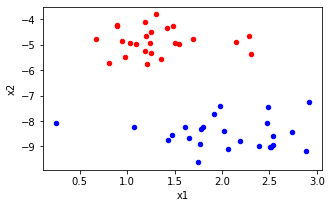

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


separatable_data = make_blobs(n_samples=50, centers=2, random_state=129, cluster_std=0.6)

separatable_df = pd.DataFrame({
                    "x1": separatable_data[0][:,0],
                    "x2": separatable_data[0][:,1],
                    "y": separatable_data[1]
                 })
separatable_df.y = separatable_df.y * 2 -1

fig, ax = plt.subplots(figsize=(5, 3))
for y, c in zip([-1, 1], ["red", "blue"]):
    separatable_df[(separatable_df.y == y)].plot.scatter(x="x1", y="x2", color=c, ax=ax)

線形分離不可能なデータを作成する。

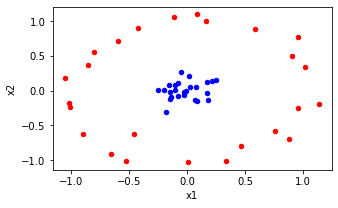

In [2]:
from sklearn.datasets import make_circles


unseparatable_data = make_circles(n_samples=50, factor=0.1, noise=0.1)

unseparatable_df = pd.DataFrame({
                    "x1": unseparatable_data[0][:,0],
                    "x2": unseparatable_data[0][:,1],
                    "y": unseparatable_data[1]
                 })

unseparatable_df.y = unseparatable_df.y * 2 - 1
fig, ax = plt.subplots(figsize=(5, 3))
for y, c in zip([-1, 1], ["red", "blue"]):
    unseparatable_df[(unseparatable_df.y == y)].plot.scatter(x="x1", y="x2", color=c, ax=ax)

## 線形SVMの実装

scikit-learnによる実装では、`SVC`のクラスにカーネルの種類を指定することで簡単にモデルを作ることができる。

In [3]:
from sklearn.svm import SVC

linear = SVC(kernel="linear")
linear.fit(separatable_df[["x1", "x2"]], separatable_df.y)

SVC(kernel='linear')

`linear.support_`でサポートベクトルとして使われた事例を確認する。

In [4]:
linear.support_

array([ 4, 30, 40], dtype=int32)

In [5]:
support_features = separatable_df.iloc[linear.support_]
support_features

,x1,x2,y
4,1.211843,-5.764191,-1
30,2.306781,-5.380518,-1
40,1.978696,-7.407928,1


サポートベクトルを描画する`draw_supports`関数を作成する。

In [6]:
def draw_supports(model, data):
    fig, ax = plt.subplots(figsize=(5, 3))
    # plot support vector
    for y, c in zip([-1, 1], ["red", "blue"]):
        for m in ("o", "*"):
            if m == "o":
                _df = data[~data.index.isin(model.support_)]
                s = 10
            else:
                _df = data.iloc[model.support_]
                s = 100
            _df = _df[_df.y == y]
            _df.plot.scatter(x="x1", y="x2", color=c, ax=ax, marker=m, s=s)
    
    return ax

線形の分離平面を描画する。$\pmb{w}^*$は`linear.coef_`、$b^*$は` linear.intercept_`に格納されている。

<AxesSubplot:xlabel='x1', ylabel='x2'>

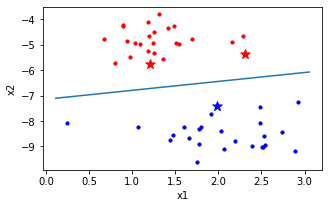

In [7]:
ax = draw_supports(linear, separatable_df)

# plot boundary
x1_values = ax.get_xlim()
x2_values = [-(linear.coef_[0][0] * x1 + linear.intercept_[0]) / linear.coef_[0][1] for x1 in x1_values]
pd.Series(x2_values, index=x1_values).plot.line(ax=ax)

双対問題の制約条件である、$\sum_{i=1}^{N} \alpha_i y_i = 0$が満たされているか確認する。

In [8]:
import numpy as np


np.testing.assert_almost_equal(np.sum(linear.dual_coef_[0]), 0)

重みである`model.coef_[0]`が$\pmb{w}^* = \sum_{i=1}^{N} \alpha_i y_i \pmb{x}_i$から計算されていることを確認する。

In [9]:
np.testing.assert_allclose(linear.coef_[0], linear.dual_coef_[0] @ support_features[["x1", "x2"]].values)

バイアスである`model.intercept_[0]`が$b^*= y_s -\pmb{w}^* \cdot \pmb{x}_{s}$から計算されていることを確認する。

In [10]:
np.testing.assert_almost_equal(
    linear.intercept_[0],
    np.min(support_features["y"] - linear.coef_[0] @ support_features[["x1", "x2"]].values.T),
    decimal=3
)

なお、線形分離不能なデータに対しては分離ができない。

<AxesSubplot:xlabel='x1', ylabel='x2'>

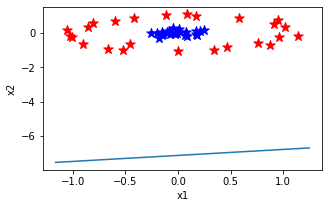

In [11]:
linear_ = SVC(kernel="linear")
linear_.fit(unseparatable_df[["x1", "x2"]], unseparatable_df.y)
ax = draw_supports(linear_, unseparatable_df)
x1_values = ax.get_xlim()
x2_values = [-(linear.coef_[0][0] * x1 + linear.intercept_[0]) / linear.coef_[0][1] for x1 in x1_values]
pd.Series(x2_values, index=x1_values).plot.line(ax=ax)

## 非線形SVMの実装

多項式のカーネル関数を実装する。

In [12]:
poly = SVC(kernel="poly", degree=2, C=1e6)
poly.fit(unseparatable_df[["x1", "x2"]], unseparatable_df.y)

SVC(C=1000000.0, degree=2, kernel='poly')

サポートベクトルをプロットする。

<AxesSubplot:xlabel='x1', ylabel='x2'>

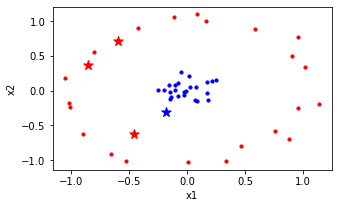

In [13]:
draw_supports(poly, unseparatable_df)

各事例に対し学習済みのモデルである`decision_function`がどのように判断しているのかを描画する。

<AxesSubplot:xlabel='x1', ylabel='x2'>

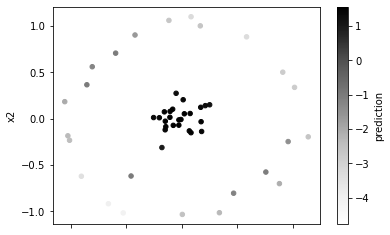

In [14]:
pd.DataFrame({
    "x1": unseparatable_df.x1,
    "x2": unseparatable_df.x2,
    "prediction": poly.decision_function(unseparatable_df[["x1", "x2"]])
}).plot.scatter(x="x1", y="x2", c="prediction")

なお、多項式の自由度(`degree`)を指定しないと大量のサポートベクトルが生まれる(過学習する?)。

In [15]:
poly_ = SVC(kernel="poly", C=1e6)
poly_.fit(unseparatable_df[["x1", "x2"]], unseparatable_df.y)

SVC(C=1000000.0, kernel='poly')

<AxesSubplot:xlabel='x1', ylabel='x2'>

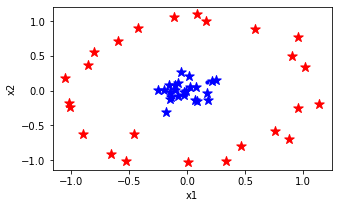

In [16]:
draw_supports(poly_, unseparatable_df)

RBFカーネルでも実装する。

In [17]:
rbf = SVC(kernel="rbf", C=1e6)
rbf.fit(unseparatable_df[["x1", "x2"]], unseparatable_df.y)

SVC(C=1000000.0)

<AxesSubplot:xlabel='x1', ylabel='x2'>

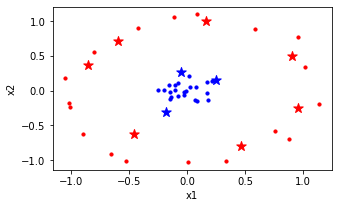

In [18]:
draw_supports(rbf, unseparatable_df)

各事例に対し学習済みのモデルである`decision_function`がどのように判断しているのかを描画する。

<AxesSubplot:xlabel='x1', ylabel='x2'>

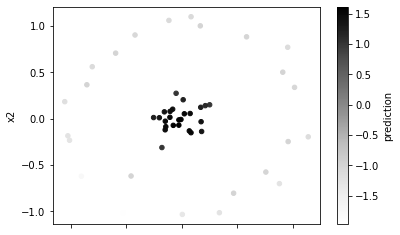

In [19]:
pd.DataFrame({
    "x1": unseparatable_df.x1,
    "x2": unseparatable_df.x2,
    "prediction": rbf.decision_function(unseparatable_df[["x1", "x2"]])
}).plot.scatter(x="x1", y="x2", c="prediction")